## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

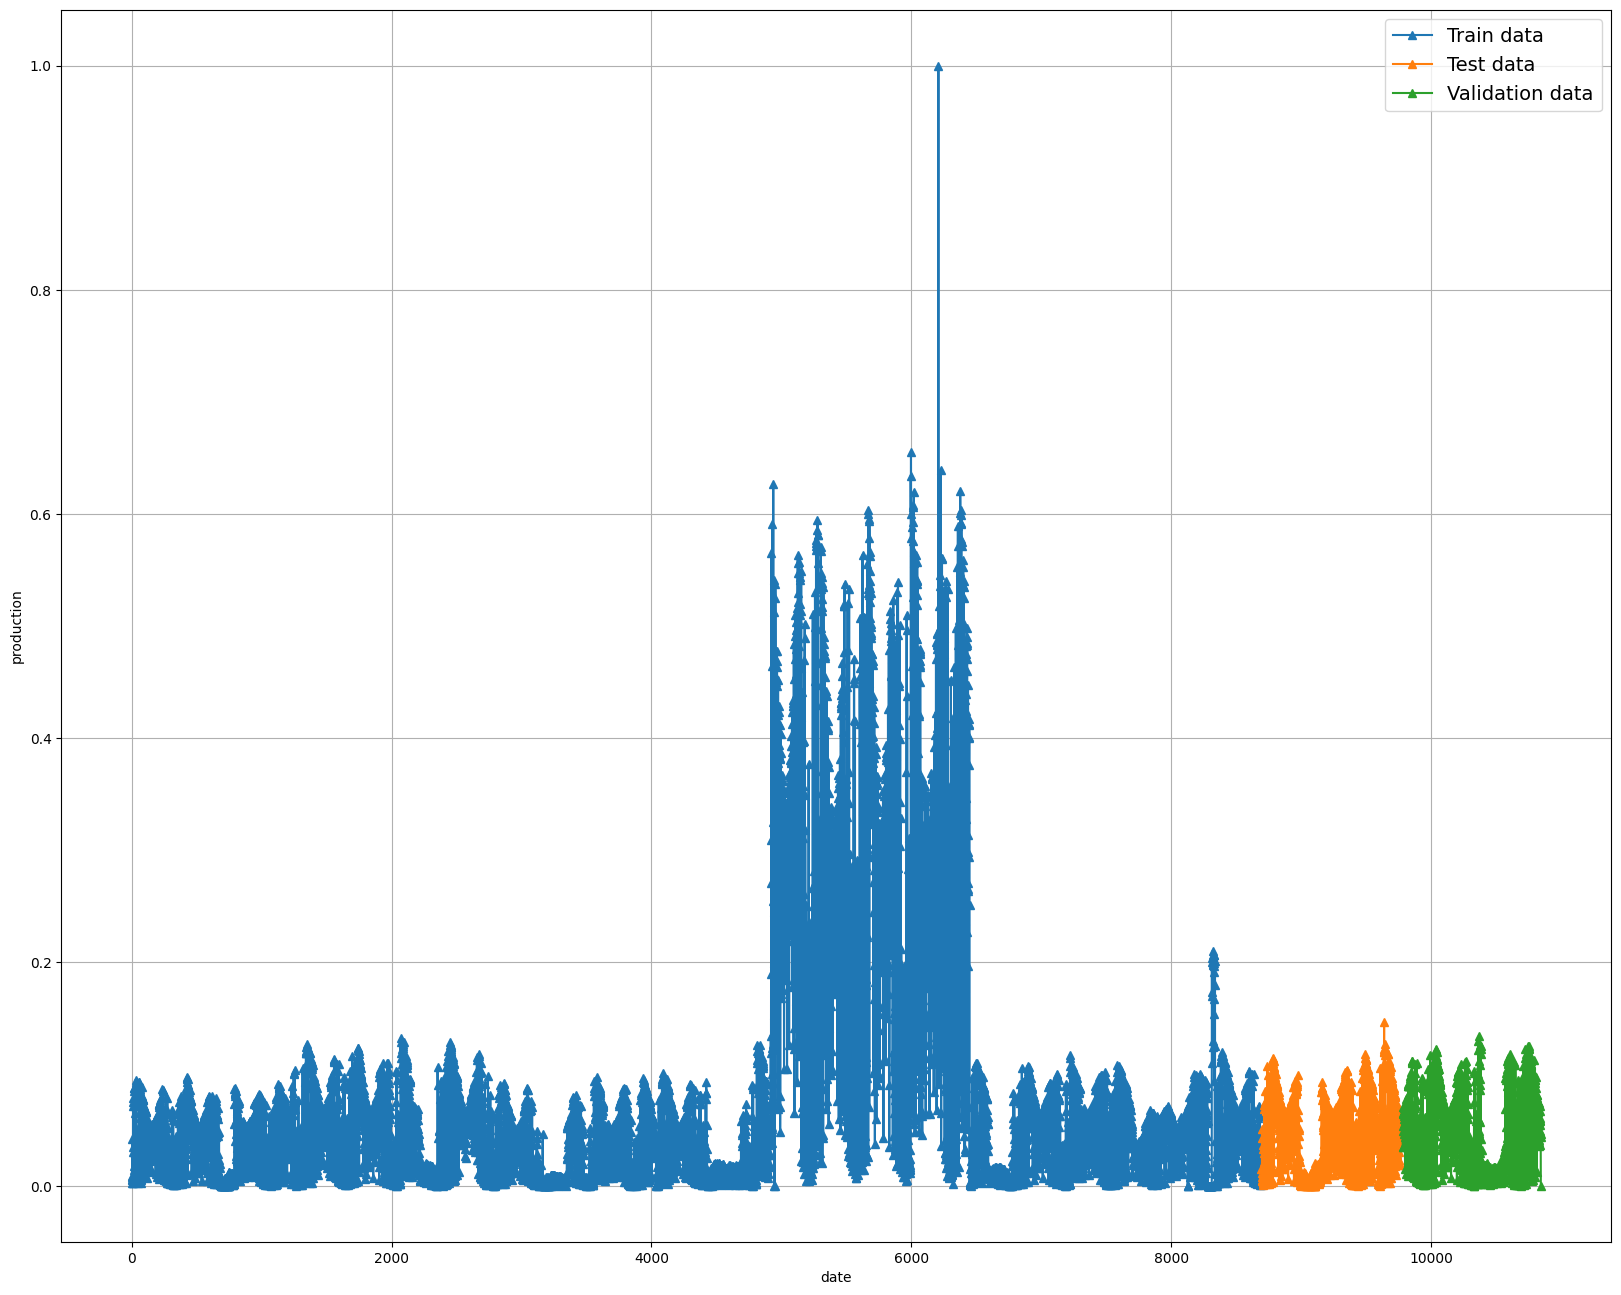

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 32
kernel_size = 1
activation = 'relu'
dense_units = 32
learning_rate = 0.0025360526576190816

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 32)         8704      
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 32)             8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 18113 (70.75 KB)
Trainable params: 18113 (70.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 11:23:57] [setup] RAM Tracking...
[codecarbon INFO @ 11:23:57] [setup] CPU Tracking...
[codecarbon WARNING @ 11:23:57] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:23:59] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 11:23:59] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 11:23:59] [setup] GPU Tracking...
[codecarbon INFO @ 11:24:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:24:01] >>> Tracker's metadata:
[codecarbon INFO @ 11:24:01]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 11:24:01]   Python version: 3.11.3
[codecarbon INFO @ 11:24:01]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:24:01]   Available RAM : 31.711 GB
[codecarbon INFO @ 11:24:01]   CPU count: 20
[codecarbon INFO @ 11:24:01]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 11:24:11] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:24:11] Energy consumed for all CPUs : 0.000119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:24:12] Energy consumed for all GPUs : 0.000002 kWh. Total GPU Power : 0.8641270985996438 W
[codecarbon INFO @ 11:24:12] 0.000154 kWh of electricity used since the beginning.


17/17 [==============================] - 17s 230ms/step - loss: 0.0528 - val_loss: 0.0302
Epoch 2/300
17/17 [==============================] - 2s 135ms/step - loss: 0.0413 - val_loss: 0.0287
Epoch 3/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0423

[codecarbon INFO @ 11:24:21] Energy consumed for RAM : 0.000062 kWh. RAM Power : 11.891499996185303 W


 7/17 [===========>..................] - ETA: 1s - loss: 0.0422

[codecarbon INFO @ 11:24:21] Energy consumed for all CPUs : 0.000220 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 117ms/step - loss: 0.0399 - val_loss: 0.0282
Epoch 4/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0381

[codecarbon INFO @ 11:24:22] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 3.9025437362026847 W
[codecarbon INFO @ 11:24:22] 0.000294 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 104ms/step - loss: 0.0399 - val_loss: 0.0280
Epoch 5/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0392 - val_loss: 0.0275
Epoch 6/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0385 - val_loss: 0.0278
Epoch 7/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0375 - val_loss: 0.0269
Epoch 8/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0382

[codecarbon INFO @ 11:24:31] Energy consumed for RAM : 0.000090 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:24:31] Energy consumed for all CPUs : 0.000322 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 112ms/step - loss: 0.0379 - val_loss: 0.0263
Epoch 9/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0371

[codecarbon INFO @ 11:24:32] Energy consumed for all GPUs : 0.000022 kWh. Total GPU Power : 4.239034590591379 W
[codecarbon INFO @ 11:24:32] 0.000434 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0372 - val_loss: 0.0269
Epoch 10/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0374 - val_loss: 0.0278
Epoch 11/300
17/17 [==============================] - 2s 115ms/step - loss: 0.0362 - val_loss: 0.0259
Epoch 12/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0356 - val_loss: 0.0259
Epoch 13/300
17/17 [==============================] - 2s 117ms/step - loss: 0.0359 - val_loss: 0.0255
Epoch 14/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0369

[codecarbon INFO @ 11:24:41] Energy consumed for RAM : 0.000118 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:24:41] Energy consumed for all CPUs : 0.000424 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 100ms/step - loss: 0.0361 - val_loss: 0.0258
Epoch 15/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0340

[codecarbon INFO @ 11:24:42] Energy consumed for all GPUs : 0.000032 kWh. Total GPU Power : 4.030403119176307 W
[codecarbon INFO @ 11:24:42] 0.000574 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 104ms/step - loss: 0.0356 - val_loss: 0.0256
Epoch 16/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0351 - val_loss: 0.0262
Epoch 17/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0353 - val_loss: 0.0279
Epoch 18/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0350 - val_loss: 0.0256
Epoch 19/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0340

[codecarbon INFO @ 11:24:51] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:24:51] Energy consumed for all CPUs : 0.000526 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 108ms/step - loss: 0.0341 - val_loss: 0.0256
Epoch 20/300
10/17 [================>.............] - ETA: 0s - loss: 0.0337

[codecarbon INFO @ 11:24:52] Energy consumed for all GPUs : 0.000041 kWh. Total GPU Power : 4.064621770637501 W
[codecarbon INFO @ 11:24:52] 0.000714 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 100ms/step - loss: 0.0342 - val_loss: 0.0248
Epoch 21/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0349 - val_loss: 0.0254
Epoch 22/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0341 - val_loss: 0.0243
Epoch 23/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0339 - val_loss: 0.0253
Epoch 24/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0340 - val_loss: 0.0254
Epoch 25/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0328

[codecarbon INFO @ 11:25:01] Energy consumed for RAM : 0.000175 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:25:01] Energy consumed for all CPUs : 0.000627 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 98ms/step - loss: 0.0337 - val_loss: 0.0241
Epoch 26/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0337

[codecarbon INFO @ 11:25:02] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 4.446686065101089 W
[codecarbon INFO @ 11:25:02] 0.000854 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0334 - val_loss: 0.0245
Epoch 27/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0334 - val_loss: 0.0243
Epoch 28/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0333 - val_loss: 0.0262
Epoch 29/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0340 - val_loss: 0.0246
Epoch 30/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0338

[codecarbon INFO @ 11:25:11] Energy consumed for RAM : 0.000204 kWh. RAM Power : 11.891499996185303 W


17/17 [==============================] - ETA: 0s - loss: 0.0337

[codecarbon INFO @ 11:25:11] Energy consumed for all CPUs : 0.000729 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 114ms/step - loss: 0.0337 - val_loss: 0.0256
Epoch 31/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0321

[codecarbon INFO @ 11:25:12] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 4.0659282992292125 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0325

[codecarbon INFO @ 11:25:12] 0.000994 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0331 - val_loss: 0.0240
Epoch 32/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0331 - val_loss: 0.0249
Epoch 33/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0329 - val_loss: 0.0240
Epoch 34/300
17/17 [==============================] - 2s 115ms/step - loss: 0.0328 - val_loss: 0.0237
Epoch 35/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0335 - val_loss: 0.0255
Epoch 36/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0349

[codecarbon INFO @ 11:25:21] Energy consumed for RAM : 0.000232 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:25:21] Energy consumed for all CPUs : 0.000831 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 94ms/step - loss: 0.0341 - val_loss: 0.0254
Epoch 37/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0331

[codecarbon INFO @ 11:25:22] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 4.078608128507958 W
[codecarbon INFO @ 11:25:22] 0.001134 kWh of electricity used since the beginning.


 7/17 [===========>..................] - ETA: 0s - loss: 0.0328

[codecarbon INFO @ 11:25:22] 0.000278 g.CO2eq/s mean an estimation of 8.778075757290765 kg.CO2eq/year


17/17 [==============================] - 2s 109ms/step - loss: 0.0327 - val_loss: 0.0236
Epoch 38/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0332 - val_loss: 0.0244
Epoch 39/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0339 - val_loss: 0.0245
Epoch 40/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0331 - val_loss: 0.0245
Epoch 41/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0327

[codecarbon INFO @ 11:25:31] Energy consumed for RAM : 0.000260 kWh. RAM Power : 11.891499996185303 W


17/17 [==============================] - ETA: 0s - loss: 0.0326

[codecarbon INFO @ 11:25:31] Energy consumed for all CPUs : 0.000933 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 120ms/step - loss: 0.0326 - val_loss: 0.0232
Epoch 42/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0322

[codecarbon INFO @ 11:25:32] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 4.101766099037341 W
[codecarbon INFO @ 11:25:32] 0.001274 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0317 - val_loss: 0.0221
Epoch 43/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0324 - val_loss: 0.0230
Epoch 44/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0321 - val_loss: 0.0254
Epoch 45/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0318 - val_loss: 0.0220
Epoch 46/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0313 - val_loss: 0.0225
Epoch 47/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0298

[codecarbon INFO @ 11:25:41] Energy consumed for RAM : 0.000289 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:25:41] Energy consumed for all CPUs : 0.001034 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 104ms/step - loss: 0.0315 - val_loss: 0.0218
Epoch 48/300


[codecarbon INFO @ 11:25:42] Energy consumed for all GPUs : 0.000091 kWh. Total GPU Power : 4.109572378343331 W
[codecarbon INFO @ 11:25:42] 0.001414 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 106ms/step - loss: 0.0317 - val_loss: 0.0227
Epoch 49/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0315 - val_loss: 0.0219
Epoch 50/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0309 - val_loss: 0.0210
Epoch 51/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0307 - val_loss: 0.0221
Epoch 52/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0307

[codecarbon INFO @ 11:25:51] Energy consumed for RAM : 0.000317 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:25:51] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 110ms/step - loss: 0.0308 - val_loss: 0.0207
Epoch 53/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0311

[codecarbon INFO @ 11:25:52] Energy consumed for all GPUs : 0.000101 kWh. Total GPU Power : 4.122095343051538 W
[codecarbon INFO @ 11:25:52] 0.001554 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 104ms/step - loss: 0.0302 - val_loss: 0.0203
Epoch 54/300
17/17 [==============================] - 2s 115ms/step - loss: 0.0302 - val_loss: 0.0198
Epoch 55/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0305 - val_loss: 0.0212
Epoch 56/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0305 - val_loss: 0.0209
Epoch 57/300
17/17 [==============================] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 11:26:01] Energy consumed for RAM : 0.000346 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:26:01] Energy consumed for all CPUs : 0.001238 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 110ms/step - loss: 0.0301 - val_loss: 0.0200
Epoch 58/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0298

[codecarbon INFO @ 11:26:02] Energy consumed for all GPUs : 0.000111 kWh. Total GPU Power : 4.100057543554766 W
[codecarbon INFO @ 11:26:02] 0.001694 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0295 - val_loss: 0.0205
Epoch 59/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0293 - val_loss: 0.0204
Epoch 60/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0299 - val_loss: 0.0208
Epoch 61/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0296 - val_loss: 0.0204
Epoch 62/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0300 - val_loss: 0.0201
Epoch 63/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0289

[codecarbon INFO @ 11:26:11] Energy consumed for RAM : 0.000374 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:26:11] Energy consumed for all CPUs : 0.001340 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 105ms/step - loss: 0.0295 - val_loss: 0.0203
Epoch 64/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0301

[codecarbon INFO @ 11:26:12] Energy consumed for all GPUs : 0.000121 kWh. Total GPU Power : 4.1131471365235335 W
[codecarbon INFO @ 11:26:12] 0.001834 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 105ms/step - loss: 0.0296 - val_loss: 0.0196
Epoch 65/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0292 - val_loss: 0.0209
Epoch 66/300
17/17 [==============================] - 2s 116ms/step - loss: 0.0295 - val_loss: 0.0194
Epoch 67/300
17/17 [==============================] - 2s 116ms/step - loss: 0.0288 - val_loss: 0.0187
Epoch 68/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0290

[codecarbon INFO @ 11:26:21] Energy consumed for RAM : 0.000402 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:26:21] Energy consumed for all CPUs : 0.001441 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 112ms/step - loss: 0.0291 - val_loss: 0.0196
Epoch 69/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0304

[codecarbon INFO @ 11:26:22] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 4.155173922166062 W
[codecarbon INFO @ 11:26:22] 0.001974 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 99ms/step - loss: 0.0298 - val_loss: 0.0187
Epoch 70/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0297 - val_loss: 0.0187
Epoch 71/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0297 - val_loss: 0.0196
Epoch 72/300
17/17 [==============================] - 2s 119ms/step - loss: 0.0288 - val_loss: 0.0183
Epoch 73/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0280 - val_loss: 0.0185
Epoch 74/300


[codecarbon INFO @ 11:26:31] Energy consumed for RAM : 0.000431 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:26:31] Energy consumed for all CPUs : 0.001543 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0284

[codecarbon INFO @ 11:26:32] Energy consumed for all GPUs : 0.000141 kWh. Total GPU Power : 4.160120555687778 W
[codecarbon INFO @ 11:26:32] 0.002114 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0280 - val_loss: 0.0182
Epoch 75/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0279 - val_loss: 0.0184
Epoch 76/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0287 - val_loss: 0.0183
Epoch 77/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0281 - val_loss: 0.0195
Epoch 78/300
17/17 [==============================] - 2s 117ms/step - loss: 0.0288 - val_loss: 0.0179
Epoch 79/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0279

[codecarbon INFO @ 11:26:41] Energy consumed for RAM : 0.000459 kWh. RAM Power : 11.891499996185303 W


 8/17 [=============>................] - ETA: 0s - loss: 0.0275

[codecarbon INFO @ 11:26:41] Energy consumed for all CPUs : 0.001645 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 105ms/step - loss: 0.0282 - val_loss: 0.0186
Epoch 80/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0280

[codecarbon INFO @ 11:26:42] Energy consumed for all GPUs : 0.000150 kWh. Total GPU Power : 4.028979790385643 W
[codecarbon INFO @ 11:26:42] 0.002254 kWh of electricity used since the beginning.


 5/17 [=======>......................] - ETA: 1s - loss: 0.0276

[codecarbon INFO @ 11:26:42] 0.000280 g.CO2eq/s mean an estimation of 8.821595648757063 kg.CO2eq/year


17/17 [==============================] - 2s 106ms/step - loss: 0.0283 - val_loss: 0.0183
Epoch 81/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0279 - val_loss: 0.0190
Epoch 82/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0279 - val_loss: 0.0186
Epoch 83/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0280 - val_loss: 0.0183
Epoch 84/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0277

[codecarbon INFO @ 11:26:51] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:26:51] Energy consumed for all CPUs : 0.001747 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 108ms/step - loss: 0.0277 - val_loss: 0.0193
Epoch 85/300
10/17 [================>.............] - ETA: 0s - loss: 0.0276

[codecarbon INFO @ 11:26:52] Energy consumed for all GPUs : 0.000159 kWh. Total GPU Power : 3.863684670942261 W
[codecarbon INFO @ 11:26:52] 0.002394 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 99ms/step - loss: 0.0274 - val_loss: 0.0174
Epoch 86/300
17/17 [==============================] - 2s 95ms/step - loss: 0.0274 - val_loss: 0.0192
Epoch 87/300
17/17 [==============================] - 1s 83ms/step - loss: 0.0275 - val_loss: 0.0178
Epoch 88/300
17/17 [==============================] - 2s 91ms/step - loss: 0.0272 - val_loss: 0.0180
Epoch 89/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0275 - val_loss: 0.0182
Epoch 90/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0266 - val_loss: 0.0174
Epoch 91/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0260

[codecarbon INFO @ 11:27:01] Energy consumed for RAM : 0.000516 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:01] Energy consumed for all CPUs : 0.001849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:27:01] Energy consumed for all GPUs : 0.000178 kWh. Total GPU Power : 7.637166999638029 W
[codecarbon INFO @ 11:27:01] 0.002542 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 100ms/step - loss: 0.0273 - val_loss: 0.0178
Epoch 92/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0272 - val_loss: 0.0179
Epoch 93/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0271 - val_loss: 0.0174
Epoch 94/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0268 - val_loss: 0.0175
Epoch 95/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0266 - val_loss: 0.0171
Epoch 96/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0267

[codecarbon INFO @ 11:27:11] Energy consumed for RAM : 0.000549 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:11] Energy consumed for all CPUs : 0.001967 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 106ms/step - loss: 0.0268 - val_loss: 0.0167
Epoch 97/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0265

[codecarbon INFO @ 11:27:12] Energy consumed for all GPUs : 0.000180 kWh. Total GPU Power : 0.6687071613623171 W
[codecarbon INFO @ 11:27:12] 0.002695 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 91ms/step - loss: 0.0269 - val_loss: 0.0176
Epoch 98/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0270 - val_loss: 0.0169
Epoch 99/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0262 - val_loss: 0.0172
Epoch 100/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0266 - val_loss: 0.0177
Epoch 101/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0271 - val_loss: 0.0173
Epoch 102/300
10/17 [================>.............] - ETA: 0s - loss: 0.0269

[codecarbon INFO @ 11:27:21] Energy consumed for RAM : 0.000577 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:21] Energy consumed for all CPUs : 0.002069 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 96ms/step - loss: 0.0265 - val_loss: 0.0176
Epoch 103/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0268

[codecarbon INFO @ 11:27:22] Energy consumed for all GPUs : 0.000190 kWh. Total GPU Power : 4.205013533066797 W
[codecarbon INFO @ 11:27:22] 0.002835 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0267 - val_loss: 0.0179
Epoch 104/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0267 - val_loss: 0.0183
Epoch 105/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0261 - val_loss: 0.0180
Epoch 106/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0262 - val_loss: 0.0169
Epoch 107/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0260 - val_loss: 0.0175
Epoch 108/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0277

[codecarbon INFO @ 11:27:31] Energy consumed for RAM : 0.000606 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:31] Energy consumed for all CPUs : 0.002170 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 95ms/step - loss: 0.0265 - val_loss: 0.0181
Epoch 109/300
 6/17 [=========>....................] - ETA: 0s - loss: 0.0263

[codecarbon INFO @ 11:27:32] Energy consumed for all GPUs : 0.000200 kWh. Total GPU Power : 4.29891910376236 W
[codecarbon INFO @ 11:27:32] 0.002976 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0262 - val_loss: 0.0167
Epoch 110/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0263 - val_loss: 0.0175
Epoch 111/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0265 - val_loss: 0.0167
Epoch 112/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0258 - val_loss: 0.0172
Epoch 113/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0258 - val_loss: 0.0172
Epoch 114/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0250

[codecarbon INFO @ 11:27:41] Energy consumed for RAM : 0.000634 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:41] Energy consumed for all CPUs : 0.002272 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0270 - val_loss: 0.0190
Epoch 115/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0253

[codecarbon INFO @ 11:27:42] Energy consumed for all GPUs : 0.000211 kWh. Total GPU Power : 4.51409746209332 W
[codecarbon INFO @ 11:27:42] 0.003117 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 100ms/step - loss: 0.0262 - val_loss: 0.0171
Epoch 116/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0261 - val_loss: 0.0160
Epoch 117/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0258 - val_loss: 0.0181
Epoch 118/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0254 - val_loss: 0.0173
Epoch 119/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0252 - val_loss: 0.0164
Epoch 120/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0227

[codecarbon INFO @ 11:27:51] Energy consumed for RAM : 0.000662 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:27:51] Energy consumed for all CPUs : 0.002374 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0254

[codecarbon INFO @ 11:27:52] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 4.1620629665296685 W
[codecarbon INFO @ 11:27:52] 0.003257 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0254 - val_loss: 0.0175
Epoch 121/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0252 - val_loss: 0.0169
Epoch 122/300
17/17 [==============================] - 2s 86ms/step - loss: 0.0255 - val_loss: 0.0165
Epoch 123/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0254 - val_loss: 0.0181
Epoch 124/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0255 - val_loss: 0.0170
Epoch 125/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0246 - val_loss: 0.0162
Epoch 126/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0230

[codecarbon INFO @ 11:28:01] Energy consumed for RAM : 0.000691 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:28:01] Energy consumed for all CPUs : 0.002476 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0244

[codecarbon INFO @ 11:28:02] Energy consumed for all GPUs : 0.000230 kWh. Total GPU Power : 4.033058712112952 W
[codecarbon INFO @ 11:28:02] 0.003397 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0244 - val_loss: 0.0165
Epoch 127/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0236

[codecarbon INFO @ 11:28:03] 0.000285 g.CO2eq/s mean an estimation of 8.99763530275698 kg.CO2eq/year


17/17 [==============================] - 2s 102ms/step - loss: 0.0248 - val_loss: 0.0160
Epoch 128/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0251 - val_loss: 0.0160
Epoch 129/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0246 - val_loss: 0.0158
Epoch 130/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0247 - val_loss: 0.0162
Epoch 131/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0242

[codecarbon INFO @ 11:28:11] Energy consumed for RAM : 0.000719 kWh. RAM Power : 11.891499996185303 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0244

[codecarbon INFO @ 11:28:11] Energy consumed for all CPUs : 0.002577 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 104ms/step - loss: 0.0248 - val_loss: 0.0158
Epoch 132/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0247

[codecarbon INFO @ 11:28:12] Energy consumed for all GPUs : 0.000240 kWh. Total GPU Power : 4.17019138921625 W
[codecarbon INFO @ 11:28:12] 0.003537 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0250 - val_loss: 0.0170
Epoch 133/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0245 - val_loss: 0.0162
Epoch 134/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0242 - val_loss: 0.0162
Epoch 135/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0244 - val_loss: 0.0174
Epoch 136/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0241 - val_loss: 0.0156
Epoch 137/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0240

[codecarbon INFO @ 11:28:21] Energy consumed for RAM : 0.000748 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:28:21] Energy consumed for all CPUs : 0.002679 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 98ms/step - loss: 0.0241 - val_loss: 0.0163
Epoch 138/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0251

[codecarbon INFO @ 11:28:22] Energy consumed for all GPUs : 0.000250 kWh. Total GPU Power : 4.144104930446713 W
[codecarbon INFO @ 11:28:22] 0.003677 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0252 - val_loss: 0.0177
Epoch 139/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0244 - val_loss: 0.0161
Epoch 140/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0239 - val_loss: 0.0162
Epoch 141/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0242 - val_loss: 0.0160
Epoch 142/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0246 - val_loss: 0.0164
Epoch 143/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0241

[codecarbon INFO @ 11:28:31] Energy consumed for RAM : 0.000776 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:28:31] Energy consumed for all CPUs : 0.002781 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 90ms/step - loss: 0.0242 - val_loss: 0.0157
Epoch 144/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0235

[codecarbon INFO @ 11:28:32] Energy consumed for all GPUs : 0.000260 kWh. Total GPU Power : 4.157243593052553 W
[codecarbon INFO @ 11:28:32] 0.003817 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0239 - val_loss: 0.0157
Epoch 145/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0236 - val_loss: 0.0154
Epoch 146/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0236 - val_loss: 0.0167
Epoch 147/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0235 - val_loss: 0.0159
Epoch 148/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0233 - val_loss: 0.0161
Epoch 149/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0237

[codecarbon INFO @ 11:28:41] Energy consumed for RAM : 0.000805 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:28:41] Energy consumed for all CPUs : 0.002883 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 93ms/step - loss: 0.0238 - val_loss: 0.0155
Epoch 150/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0236

[codecarbon INFO @ 11:28:42] Energy consumed for all GPUs : 0.000270 kWh. Total GPU Power : 4.15323324797776 W
[codecarbon INFO @ 11:28:42] 0.003958 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0236 - val_loss: 0.0191
Epoch 151/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0236 - val_loss: 0.0160
Epoch 152/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0234 - val_loss: 0.0157
Epoch 153/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0229 - val_loss: 0.0170
Epoch 154/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0228 - val_loss: 0.0152
Epoch 155/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0233

[codecarbon INFO @ 11:28:51] Energy consumed for RAM : 0.000833 kWh. RAM Power : 11.891499996185303 W


 6/17 [=========>....................] - ETA: 1s - loss: 0.0228

[codecarbon INFO @ 11:28:51] Energy consumed for all CPUs : 0.002985 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0233 - val_loss: 0.0162
Epoch 156/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0214

[codecarbon INFO @ 11:28:53] Energy consumed for all GPUs : 0.000280 kWh. Total GPU Power : 4.154759924005325 W
[codecarbon INFO @ 11:28:53] 0.004098 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 100ms/step - loss: 0.0236 - val_loss: 0.0155
Epoch 157/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0230 - val_loss: 0.0160
Epoch 158/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0225 - val_loss: 0.0156
Epoch 159/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0226 - val_loss: 0.0151
Epoch 160/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0226 - val_loss: 0.0150
Epoch 161/300


[codecarbon INFO @ 11:29:01] Energy consumed for RAM : 0.000861 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:29:01] Energy consumed for all CPUs : 0.003086 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0227

[codecarbon INFO @ 11:29:03] Energy consumed for all GPUs : 0.000290 kWh. Total GPU Power : 4.13655325119948 W
[codecarbon INFO @ 11:29:03] 0.004238 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 89ms/step - loss: 0.0227 - val_loss: 0.0152
Epoch 162/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0228 - val_loss: 0.0147
Epoch 163/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0229 - val_loss: 0.0152
Epoch 164/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0233 - val_loss: 0.0155
Epoch 165/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0228 - val_loss: 0.0149
Epoch 166/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0220

[codecarbon INFO @ 11:29:11] Energy consumed for RAM : 0.000890 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:29:11] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0223 - val_loss: 0.0145
Epoch 167/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0222

[codecarbon INFO @ 11:29:13] Energy consumed for all GPUs : 0.000300 kWh. Total GPU Power : 4.048660279320889 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0222

[codecarbon INFO @ 11:29:13] 0.004378 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 89ms/step - loss: 0.0224 - val_loss: 0.0152
Epoch 168/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0222 - val_loss: 0.0162
Epoch 169/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0231 - val_loss: 0.0157
Epoch 170/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0223 - val_loss: 0.0149
Epoch 171/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0226 - val_loss: 0.0150
Epoch 172/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0225

[codecarbon INFO @ 11:29:21] Energy consumed for RAM : 0.000918 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:29:21] Energy consumed for all CPUs : 0.003290 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 103ms/step - loss: 0.0226 - val_loss: 0.0161
Epoch 173/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0225

[codecarbon INFO @ 11:29:23] Energy consumed for all GPUs : 0.000310 kWh. Total GPU Power : 4.134480091680096 W
[codecarbon INFO @ 11:29:23] 0.004518 kWh of electricity used since the beginning.


15/17 [=========================>....] - ETA: 0s - loss: 0.0227

[codecarbon INFO @ 11:29:23] 0.000280 g.CO2eq/s mean an estimation of 8.823365974853608 kg.CO2eq/year


17/17 [==============================] - 2s 90ms/step - loss: 0.0230 - val_loss: 0.0176
Epoch 174/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0231 - val_loss: 0.0170
Epoch 175/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0221 - val_loss: 0.0152
Epoch 176/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0221 - val_loss: 0.0145
Epoch 177/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0219 - val_loss: 0.0152
Epoch 178/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0219

[codecarbon INFO @ 11:29:31] Energy consumed for RAM : 0.000946 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:29:31] Energy consumed for all CPUs : 0.003391 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0223 - val_loss: 0.0156
Epoch 179/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0228

[codecarbon INFO @ 11:29:33] Energy consumed for all GPUs : 0.000320 kWh. Total GPU Power : 4.151047693227278 W
[codecarbon INFO @ 11:29:33] 0.004658 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0222 - val_loss: 0.0148
Epoch 180/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0215 - val_loss: 0.0161
Epoch 181/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0219 - val_loss: 0.0143
Epoch 182/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0215 - val_loss: 0.0147
Epoch 183/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0210 - val_loss: 0.0144
Epoch 184/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0212

[codecarbon INFO @ 11:29:41] Energy consumed for RAM : 0.000975 kWh. RAM Power : 11.891499996185303 W


 8/17 [=============>................] - ETA: 0s - loss: 0.0213

[codecarbon INFO @ 11:29:41] Energy consumed for all CPUs : 0.003493 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 100ms/step - loss: 0.0214 - val_loss: 0.0146
Epoch 185/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0213

[codecarbon INFO @ 11:29:43] Energy consumed for all GPUs : 0.000330 kWh. Total GPU Power : 4.190575839080262 W
[codecarbon INFO @ 11:29:43] 0.004798 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 97ms/step - loss: 0.0213 - val_loss: 0.0155
Epoch 186/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0217 - val_loss: 0.0152
Epoch 187/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0219 - val_loss: 0.0162
Epoch 188/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0222 - val_loss: 0.0154
Epoch 189/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0212 - val_loss: 0.0148
Epoch 190/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0215

[codecarbon INFO @ 11:29:51] Energy consumed for RAM : 0.001003 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:29:51] Energy consumed for all CPUs : 0.003595 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0215 - val_loss: 0.0143
Epoch 191/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0226

[codecarbon INFO @ 11:29:53] Energy consumed for all GPUs : 0.000340 kWh. Total GPU Power : 4.250241446016742 W
[codecarbon INFO @ 11:29:53] 0.004938 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 94ms/step - loss: 0.0220 - val_loss: 0.0145
Epoch 192/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0214 - val_loss: 0.0143
Epoch 193/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0209 - val_loss: 0.0156
Epoch 194/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0210 - val_loss: 0.0153
Epoch 195/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0225 - val_loss: 0.0145
Epoch 196/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0221

[codecarbon INFO @ 11:30:01] Energy consumed for RAM : 0.001032 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:01] Energy consumed for all CPUs : 0.003697 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 92ms/step - loss: 0.0215 - val_loss: 0.0164
Epoch 197/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0211

[codecarbon INFO @ 11:30:03] Energy consumed for all GPUs : 0.000350 kWh. Total GPU Power : 4.225031347682907 W
[codecarbon INFO @ 11:30:03] 0.005079 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 96ms/step - loss: 0.0212 - val_loss: 0.0143
Epoch 198/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0207 - val_loss: 0.0148
Epoch 199/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0212 - val_loss: 0.0151
Epoch 200/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0210 - val_loss: 0.0146
Epoch 201/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0209 - val_loss: 0.0141
Epoch 202/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0211

[codecarbon INFO @ 11:30:11] Energy consumed for RAM : 0.001060 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:11] Energy consumed for all CPUs : 0.003799 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 103ms/step - loss: 0.0208 - val_loss: 0.0139
Epoch 203/300


[codecarbon INFO @ 11:30:13] Energy consumed for all GPUs : 0.000360 kWh. Total GPU Power : 4.174407606417277 W
[codecarbon INFO @ 11:30:13] 0.005219 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0206 - val_loss: 0.0145
Epoch 204/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0204 - val_loss: 0.0138
Epoch 205/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0208 - val_loss: 0.0143
Epoch 206/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0205 - val_loss: 0.0146
Epoch 207/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0207

[codecarbon INFO @ 11:30:21] Energy consumed for RAM : 0.001089 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:21] Energy consumed for all CPUs : 0.003901 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 104ms/step - loss: 0.0207 - val_loss: 0.0144
Epoch 208/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0205

[codecarbon INFO @ 11:30:23] Energy consumed for all GPUs : 0.000370 kWh. Total GPU Power : 4.346592514220849 W
[codecarbon INFO @ 11:30:23] 0.005359 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0207 - val_loss: 0.0155
Epoch 209/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0204 - val_loss: 0.0140
Epoch 210/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0202 - val_loss: 0.0145
Epoch 211/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0213 - val_loss: 0.0143
Epoch 212/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0212 - val_loss: 0.0159
Epoch 213/300
17/17 [==============================] - ETA: 0s - loss: 0.0213

[codecarbon INFO @ 11:30:31] Energy consumed for RAM : 0.001117 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:31] Energy consumed for all CPUs : 0.004002 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 103ms/step - loss: 0.0213 - val_loss: 0.0140
Epoch 214/300
17/17 [==============================] - ETA: 0s - loss: 0.0212

[codecarbon INFO @ 11:30:33] Energy consumed for all GPUs : 0.000380 kWh. Total GPU Power : 4.160702964435362 W
[codecarbon INFO @ 11:30:33] 0.005500 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 74ms/step - loss: 0.0212 - val_loss: 0.0167
Epoch 215/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0215 - val_loss: 0.0153
Epoch 216/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0206 - val_loss: 0.0144
Epoch 217/300
17/17 [==============================] - 1s 88ms/step - loss: 0.0199 - val_loss: 0.0141
Epoch 218/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0199 - val_loss: 0.0138
Epoch 219/300
17/17 [==============================] - 1s 86ms/step - loss: 0.0199 - val_loss: 0.0149
Epoch 220/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0203

[codecarbon INFO @ 11:30:41] Energy consumed for RAM : 0.001145 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:41] Energy consumed for all CPUs : 0.004104 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 85ms/step - loss: 0.0204 - val_loss: 0.0140
Epoch 221/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0205

[codecarbon INFO @ 11:30:43] Energy consumed for all GPUs : 0.000390 kWh. Total GPU Power : 4.048930253162781 W
[codecarbon INFO @ 11:30:43] 0.005639 kWh of electricity used since the beginning.


12/17 [====================>.........] - ETA: 0s - loss: 0.0210

[codecarbon INFO @ 11:30:43] 0.000280 g.CO2eq/s mean an estimation of 8.832252879970289 kg.CO2eq/year


17/17 [==============================] - 1s 82ms/step - loss: 0.0209 - val_loss: 0.0138
Epoch 222/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0198 - val_loss: 0.0137
Epoch 223/300
17/17 [==============================] - 2s 91ms/step - loss: 0.0199 - val_loss: 0.0142
Epoch 224/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0196 - val_loss: 0.0144
Epoch 225/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0195 - val_loss: 0.0138
Epoch 226/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0191

[codecarbon INFO @ 11:30:51] Energy consumed for RAM : 0.001174 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:30:51] Energy consumed for all CPUs : 0.004206 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 91ms/step - loss: 0.0195 - val_loss: 0.0144
Epoch 227/300
10/17 [================>.............] - ETA: 0s - loss: 0.0198

[codecarbon INFO @ 11:30:53] Energy consumed for all GPUs : 0.000400 kWh. Total GPU Power : 4.183287434359927 W
[codecarbon INFO @ 11:30:53] 0.005779 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 86ms/step - loss: 0.0200 - val_loss: 0.0143
Epoch 228/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0205 - val_loss: 0.0143
Epoch 229/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0198 - val_loss: 0.0149
Epoch 230/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0198 - val_loss: 0.0135
Epoch 231/300
17/17 [==============================] - 1s 87ms/step - loss: 0.0195 - val_loss: 0.0139
Epoch 232/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0198 - val_loss: 0.0151
Epoch 233/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0212

[codecarbon INFO @ 11:31:01] Energy consumed for RAM : 0.001202 kWh. RAM Power : 11.891499996185303 W


 3/17 [====>.........................] - ETA: 1s - loss: 0.0211

[codecarbon INFO @ 11:31:01] Energy consumed for all CPUs : 0.004307 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 91ms/step - loss: 0.0197 - val_loss: 0.0137
Epoch 234/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0158

[codecarbon INFO @ 11:31:03] Energy consumed for all GPUs : 0.000410 kWh. Total GPU Power : 4.165693768210036 W
[codecarbon INFO @ 11:31:03] 0.005920 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 92ms/step - loss: 0.0194 - val_loss: 0.0134
Epoch 235/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0192 - val_loss: 0.0134
Epoch 236/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0198 - val_loss: 0.0133
Epoch 237/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0191 - val_loss: 0.0142
Epoch 238/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0194 - val_loss: 0.0139
Epoch 239/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0169

[codecarbon INFO @ 11:31:11] Energy consumed for RAM : 0.001231 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:31:11] Energy consumed for all CPUs : 0.004409 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0199

[codecarbon INFO @ 11:31:13] Energy consumed for all GPUs : 0.000420 kWh. Total GPU Power : 4.14734845909023 W
[codecarbon INFO @ 11:31:13] 0.006060 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0199 - val_loss: 0.0144
Epoch 240/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0195 - val_loss: 0.0141
Epoch 241/300
17/17 [==============================] - 2s 87ms/step - loss: 0.0193 - val_loss: 0.0134
Epoch 242/300
17/17 [==============================] - 2s 91ms/step - loss: 0.0194 - val_loss: 0.0135
Epoch 243/300
17/17 [==============================] - 2s 91ms/step - loss: 0.0194 - val_loss: 0.0146
Epoch 244/300
17/17 [==============================] - 1s 88ms/step - loss: 0.0193 - val_loss: 0.0137
Epoch 245/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 11:31:21] Energy consumed for RAM : 0.001259 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:31:21] Energy consumed for all CPUs : 0.004511 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 96ms/step - loss: 0.0195 - val_loss: 0.0138
Epoch 246/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0184

[codecarbon INFO @ 11:31:23] Energy consumed for all GPUs : 0.000430 kWh. Total GPU Power : 4.0238444581489405 W
[codecarbon INFO @ 11:31:23] 0.006200 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0189 - val_loss: 0.0132
Epoch 247/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0190 - val_loss: 0.0147
Epoch 248/300
17/17 [==============================] - 1s 81ms/step - loss: 0.0189 - val_loss: 0.0140
Epoch 249/300
17/17 [==============================] - 2s 91ms/step - loss: 0.0193 - val_loss: 0.0140
Epoch 250/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0192 - val_loss: 0.0135
Epoch 251/300
17/17 [==============================] - ETA: 0s - loss: 0.0191

[codecarbon INFO @ 11:31:31] Energy consumed for RAM : 0.001287 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:31:31] Energy consumed for all CPUs : 0.004613 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 87ms/step - loss: 0.0191 - val_loss: 0.0136
Epoch 252/300
17/17 [==============================] - ETA: 0s - loss: 0.0190

[codecarbon INFO @ 11:31:33] Energy consumed for all GPUs : 0.000440 kWh. Total GPU Power : 4.169845643635973 W
[codecarbon INFO @ 11:31:33] 0.006340 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 87ms/step - loss: 0.0190 - val_loss: 0.0144
Epoch 253/300
17/17 [==============================] - 2s 95ms/step - loss: 0.0188 - val_loss: 0.0140
Epoch 254/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0185 - val_loss: 0.0129
Epoch 255/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0184 - val_loss: 0.0131
Epoch 256/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0184 - val_loss: 0.0140
Epoch 257/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0194

[codecarbon INFO @ 11:31:41] Energy consumed for RAM : 0.001316 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:31:41] Energy consumed for all CPUs : 0.004714 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 105ms/step - loss: 0.0194 - val_loss: 0.0142
Epoch 258/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0192

[codecarbon INFO @ 11:31:43] Energy consumed for all GPUs : 0.000449 kWh. Total GPU Power : 4.041928943274502 W
[codecarbon INFO @ 11:31:43] 0.006479 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 94ms/step - loss: 0.0190 - val_loss: 0.0138
Epoch 259/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0185 - val_loss: 0.0134
Epoch 260/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 261/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0181 - val_loss: 0.0131
Epoch 262/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0188 - val_loss: 0.0132
Epoch 263/300
10/17 [================>.............] - ETA: 0s - loss: 0.0189

[codecarbon INFO @ 11:31:51] Energy consumed for RAM : 0.001344 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:31:51] Energy consumed for all CPUs : 0.004816 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 83ms/step - loss: 0.0190 - val_loss: 0.0139
Epoch 264/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0188

[codecarbon INFO @ 11:31:53] Energy consumed for all GPUs : 0.000459 kWh. Total GPU Power : 4.156492081911252 W
[codecarbon INFO @ 11:31:53] 0.006619 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 83ms/step - loss: 0.0191 - val_loss: 0.0133
Epoch 265/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0191 - val_loss: 0.0132
Epoch 266/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0190 - val_loss: 0.0134
Epoch 267/300
17/17 [==============================] - 1s 85ms/step - loss: 0.0181 - val_loss: 0.0137
Epoch 268/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0182 - val_loss: 0.0134
Epoch 269/300
17/17 [==============================] - ETA: 0s - loss: 0.0179

[codecarbon INFO @ 11:32:01] Energy consumed for RAM : 0.001373 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:32:01] Energy consumed for all CPUs : 0.004918 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0179 - val_loss: 0.0138
Epoch 270/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0180

[codecarbon INFO @ 11:32:03] Energy consumed for all GPUs : 0.000469 kWh. Total GPU Power : 4.264112073126621 W
[codecarbon INFO @ 11:32:03] 0.006760 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0179 - val_loss: 0.0141
Epoch 271/300


[codecarbon INFO @ 11:32:03] 0.000280 g.CO2eq/s mean an estimation of 8.827155922506233 kg.CO2eq/year


17/17 [==============================] - 1s 87ms/step - loss: 0.0180 - val_loss: 0.0135
Epoch 272/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0178 - val_loss: 0.0126
Epoch 273/300
17/17 [==============================] - 2s 88ms/step - loss: 0.0184 - val_loss: 0.0146
Epoch 274/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0188 - val_loss: 0.0133
Epoch 275/300
17/17 [==============================] - 1s 85ms/step - loss: 0.0188 - val_loss: 0.0133
Epoch 276/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0172

[codecarbon INFO @ 11:32:11] Energy consumed for RAM : 0.001401 kWh. RAM Power : 11.891499996185303 W


 8/17 [=============>................] - ETA: 0s - loss: 0.0175

[codecarbon INFO @ 11:32:11] Energy consumed for all CPUs : 0.005020 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0178 - val_loss: 0.0139
Epoch 277/300
 5/17 [=======>......................] - ETA: 0s - loss: 0.0186

[codecarbon INFO @ 11:32:13] Energy consumed for all GPUs : 0.000479 kWh. Total GPU Power : 4.065164360377983 W
[codecarbon INFO @ 11:32:13] 0.006900 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 84ms/step - loss: 0.0178 - val_loss: 0.0130
Epoch 278/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0186 - val_loss: 0.0140
Epoch 279/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0187 - val_loss: 0.0146
Epoch 280/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0182 - val_loss: 0.0130
Epoch 281/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0182 - val_loss: 0.0132
Epoch 282/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0197

[codecarbon INFO @ 11:32:21] Energy consumed for RAM : 0.001429 kWh. RAM Power : 11.891499996185303 W


 6/17 [=========>....................] - ETA: 1s - loss: 0.0193

[codecarbon INFO @ 11:32:21] Energy consumed for all CPUs : 0.005121 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0178 - val_loss: 0.0135
Epoch 283/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0181

[codecarbon INFO @ 11:32:23] Energy consumed for all GPUs : 0.000489 kWh. Total GPU Power : 4.171345992384949 W
[codecarbon INFO @ 11:32:23] 0.007040 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0183 - val_loss: 0.0138
Epoch 284/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0182 - val_loss: 0.0122
Epoch 285/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0173 - val_loss: 0.0131
Epoch 286/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0176 - val_loss: 0.0140
Epoch 287/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0175 - val_loss: 0.0127
Epoch 288/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0180

[codecarbon INFO @ 11:32:31] Energy consumed for RAM : 0.001458 kWh. RAM Power : 11.891499996185303 W


 5/17 [=======>......................] - ETA: 1s - loss: 0.0181

[codecarbon INFO @ 11:32:31] Energy consumed for all CPUs : 0.005223 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 93ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 289/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0171

[codecarbon INFO @ 11:32:33] Energy consumed for all GPUs : 0.000499 kWh. Total GPU Power : 4.292689056052645 W
[codecarbon INFO @ 11:32:33] 0.007180 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 97ms/step - loss: 0.0177 - val_loss: 0.0135
Epoch 290/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 291/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0177 - val_loss: 0.0127
Epoch 292/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0184 - val_loss: 0.0128
Epoch 293/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0177 - val_loss: 0.0136
Epoch 294/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0177

[codecarbon INFO @ 11:32:41] Energy consumed for RAM : 0.001486 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:32:41] Energy consumed for all CPUs : 0.005325 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 94ms/step - loss: 0.0178 - val_loss: 0.0132
Epoch 295/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0181

[codecarbon INFO @ 11:32:43] Energy consumed for all GPUs : 0.000511 kWh. Total GPU Power : 4.62749741145719 W
[codecarbon INFO @ 11:32:43] 0.007322 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0176 - val_loss: 0.0133
Epoch 296/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0173 - val_loss: 0.0132
Epoch 297/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0171 - val_loss: 0.0125
Epoch 298/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0173 - val_loss: 0.0142
Epoch 299/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0175 - val_loss: 0.0127
Epoch 300/300


[codecarbon INFO @ 11:32:51] Energy consumed for RAM : 0.001515 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:32:51] Energy consumed for all CPUs : 0.005427 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0172

[codecarbon INFO @ 11:32:53] Energy consumed for all GPUs : 0.000521 kWh. Total GPU Power : 4.198202836341091 W
[codecarbon INFO @ 11:32:53] 0.007462 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 91ms/step - loss: 0.0172 - val_loss: 0.0126


[codecarbon INFO @ 11:32:53] Energy consumed for RAM : 0.001515 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:32:53] Energy consumed for all CPUs : 0.005429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:32:53] Energy consumed for all GPUs : 0.000527 kWh. Total GPU Power : 119.26551000328325 W
[codecarbon INFO @ 11:32:53] 0.007471 kWh of electricity used since the beginning.


#### Ploting the loss

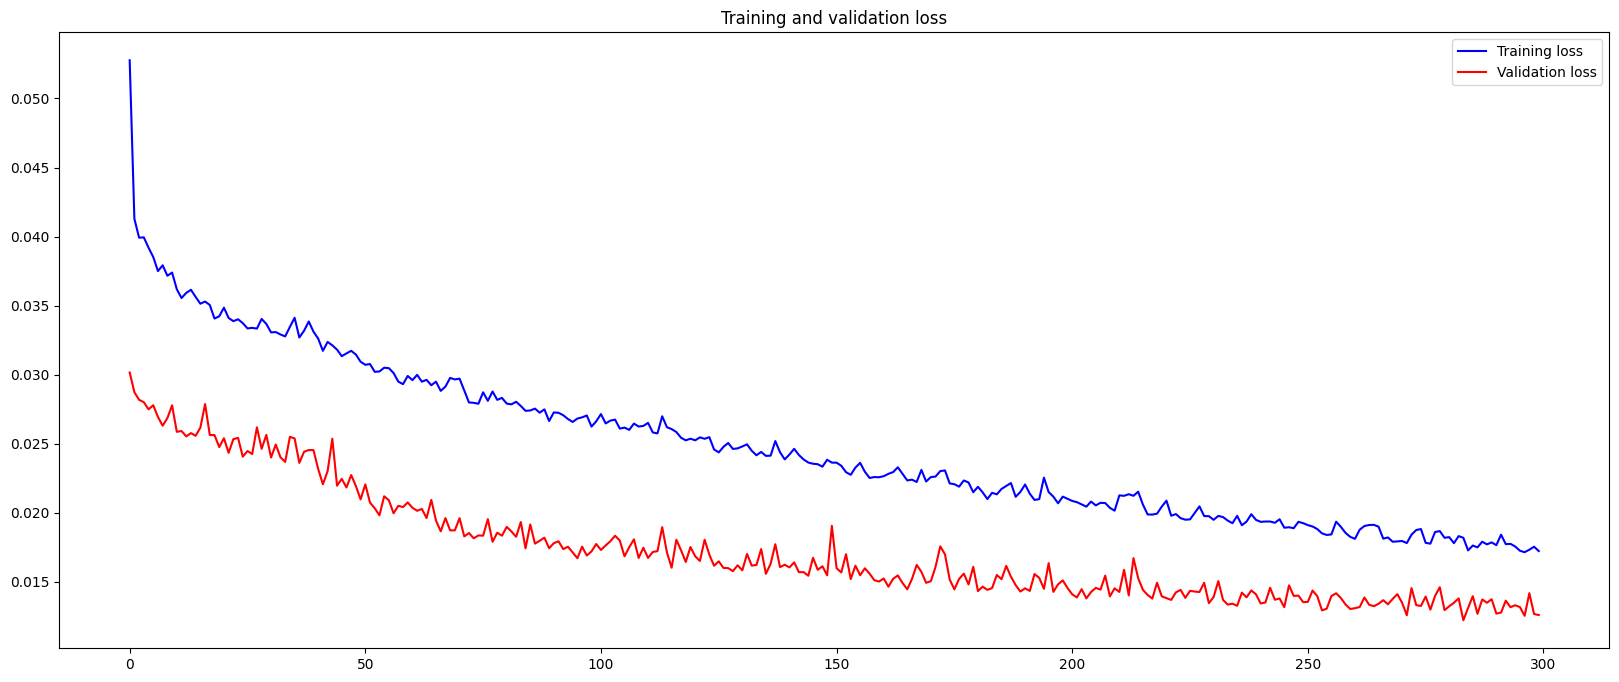

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 [==============================] - 2s 30ms/step


{'mae': 0.009965652, 'mse': 0.000269716, 'r2': 0.7589804530143738}

#### Plot predictions

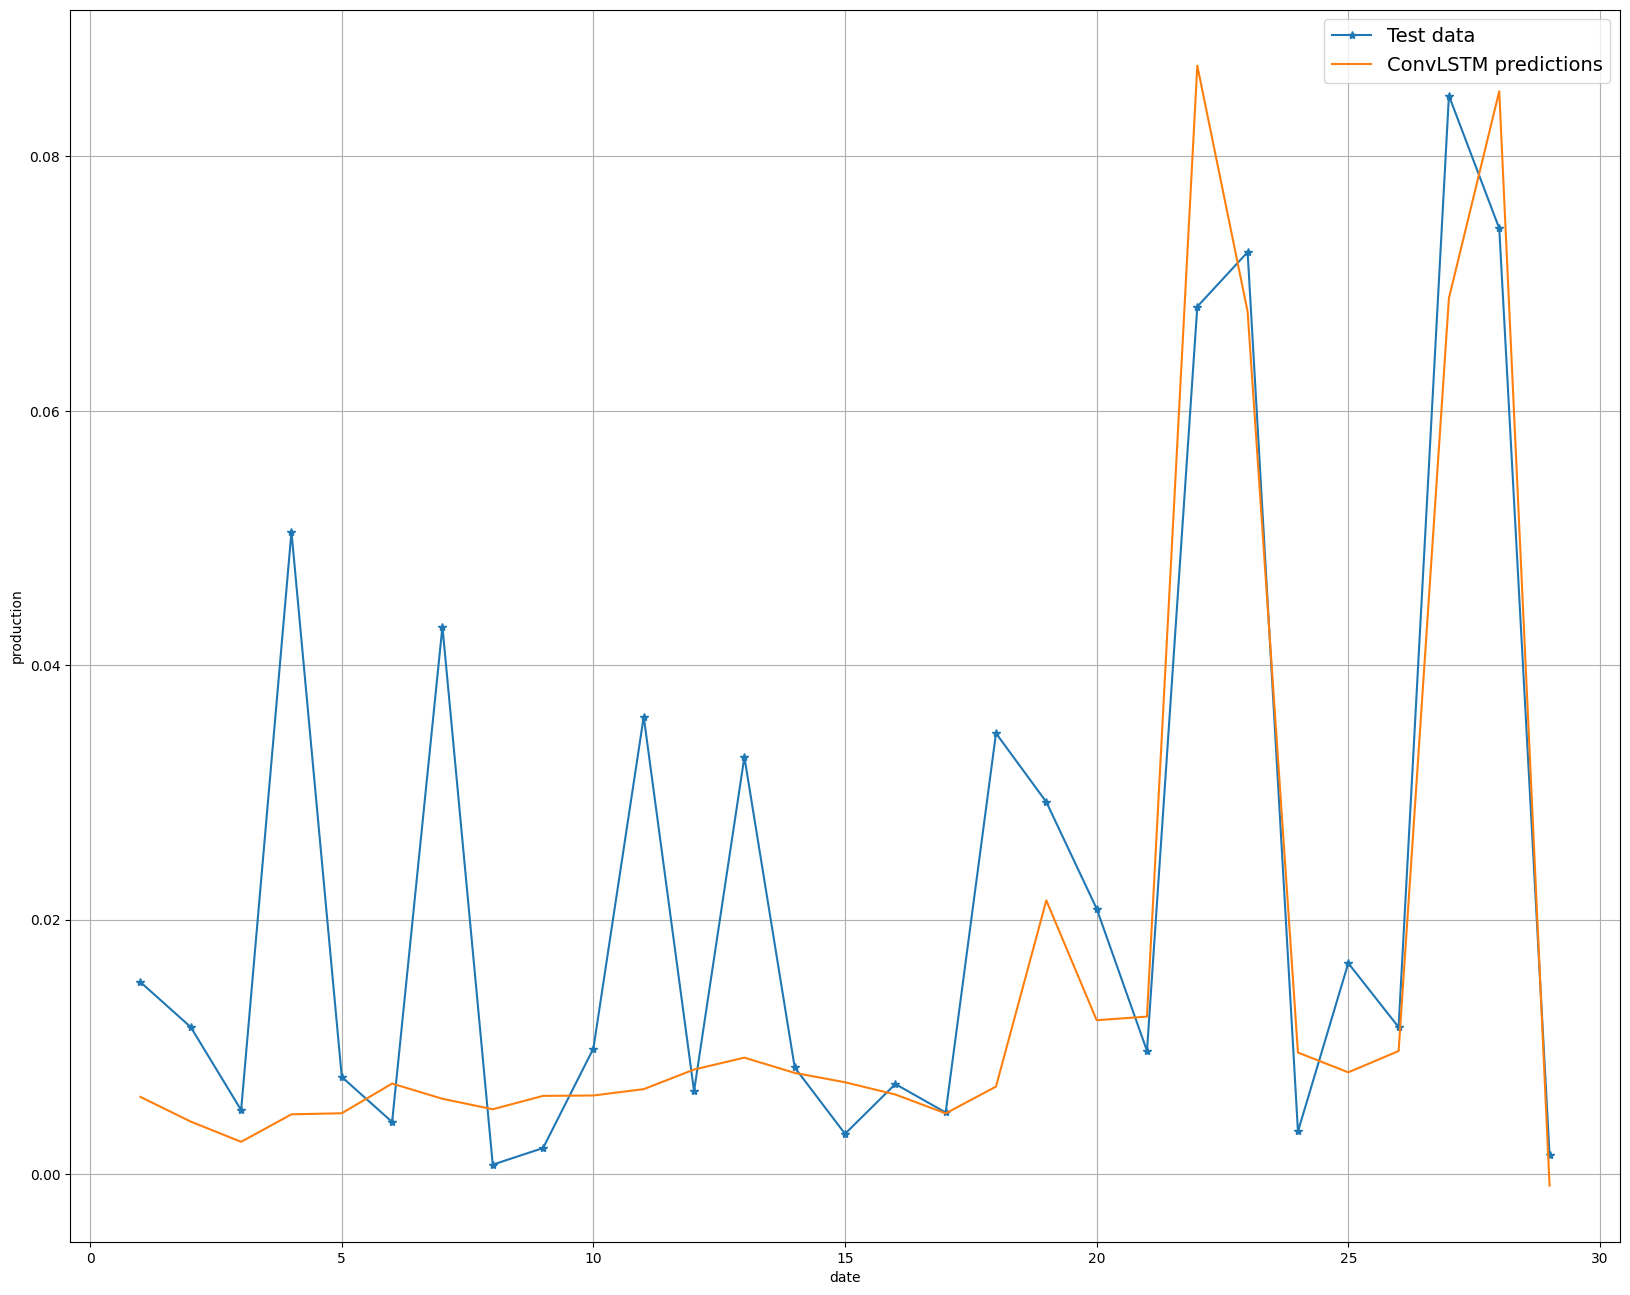

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)